In [1]:
import os
import datetime
import warnings 
warnings.filterwarnings('ignore') 
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_federated as tff

2024-03-07 21:11:27.138434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 21:11:27.178841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 21:11:27.178943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 21:11:27.179013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 21:11:27.186892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 21:11:27.187465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Set random seed for TensorFlow
tf.random.set_seed(42)
# Set random seed for Numpy
np.random.seed(42)

## Baseline Analysis 

In [3]:
csv_path = "Data/data_Florida_2005_2015_10.csv"
cols = ['average_demand', 'No_of_energy_intensive_industry', 'no_of_energy_non_Intensive_Industry', 'gdp_growth', 'popultion', 'max temp', 'mean temp', 'min temp', 'load_share', 'average_retail_sales']
df = pd.read_csv(csv_path) 
df.head()

,average_demand,No_of_energy_intensive_industry,no_of_energy_non_Intensive_Industry,gdp_growth,popultion,max temp,mean temp,min temp,load_share,average_retail_sales
0,1576.666667,4240,7304,0.810100,17773.608997,72.266667,61.266667,50.366667,9.287986,6.090000
1,1637.333333,4243,7278,1.434778,17800.980598,84.100000,73.666667,63.166667,9.410322,6.240000
2,1700.333333,4241,7270,3.368418,17855.723801,91.300000,82.433333,73.566667,7.467319,6.713333
3,1683.333333,4268,7264,0.525937,17937.838604,76.300000,65.966667,55.633333,9.360693,6.803333
4,1540.000000,4317,8247,2.272623,18047.325009,73.500000,61.300000,49.100000,9.231507,7.516667


In [4]:

start_year = 2005
end_year = 2015

quarters = []
for year in range(start_year, end_year + 1):
    for quarter in range(1, 5):
        for month in range(1 + (quarter - 1) * 3, 4 + (quarter - 1) * 3 , 4):
            quarters.append(datetime.datetime(year, month, 1))

print(len(quarters))

quarter_date = pd.to_datetime(quarters)

44


In [5]:
df.index = quarter_date

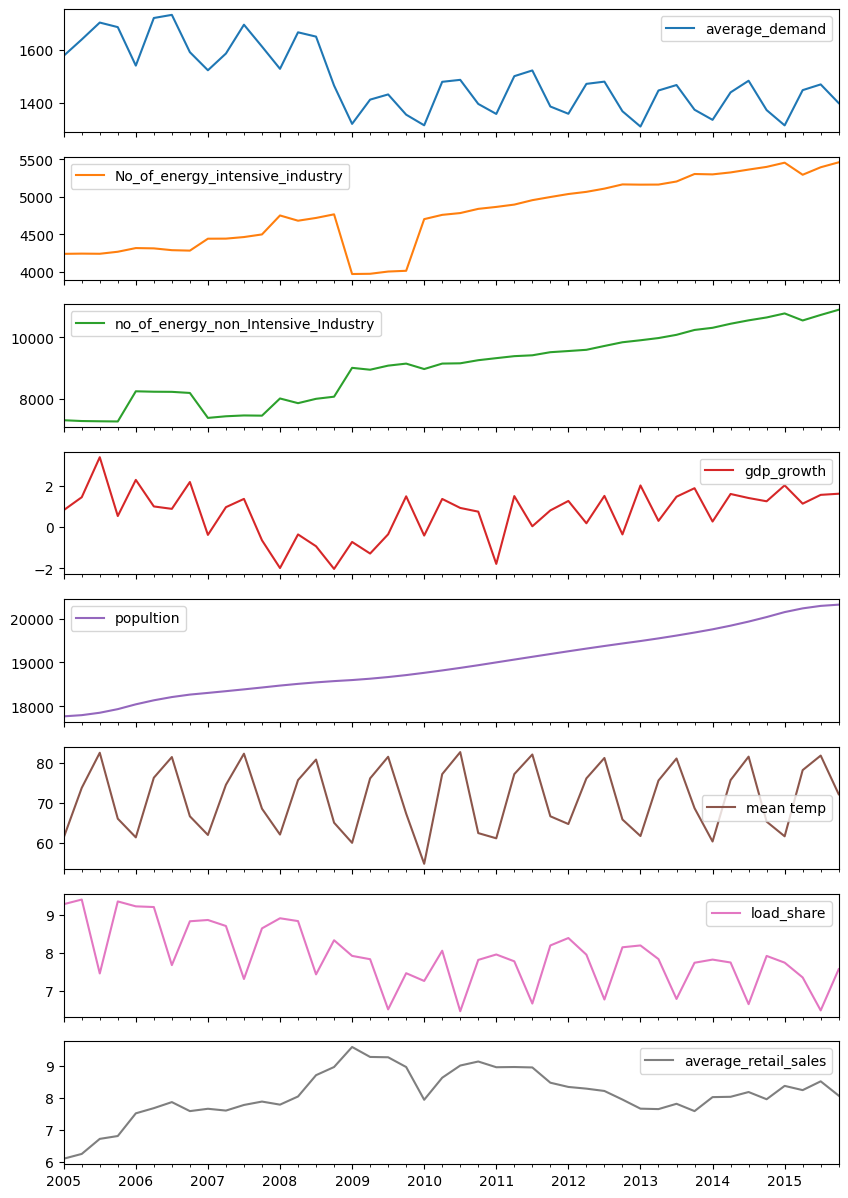

In [6]:
plot_cols =  ['average_demand', 'No_of_energy_intensive_industry', 'no_of_energy_non_Intensive_Industry', 'gdp_growth', 'popultion', 'mean temp', 'load_share', 'average_retail_sales']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True , figsize=(10,15))


In [7]:
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
average_demand,44.0,1487.007576,121.375291,1313.000000,1384.666667,1471.000000,1578.750000,1729.000000
No_of_energy_intensive_industry,44.0,4771.454545,459.748134,3971.000000,4316.000000,4775.500000,5164.500000,5461.000000
no_of_energy_non_Intensive_Industry,44.0,9045.227273,1147.866248,7264.000000,8056.500000,9154.500000,9928.000000,10904.000000
gdp_growth,44.0,0.672904,1.204722,-2.028477,-0.357489,0.935674,1.481386,3.368418
popultion,44.0,18960.245636,724.335561,17773.608997,18419.481610,18847.498702,19502.591432,20315.458548
max temp,44.0,81.846970,7.545255,66.000000,75.750000,82.600000,89.333333,91.600000
mean temp,44.0,71.307576,8.304835,54.700000,64.066667,72.866667,78.758333,82.600000
min temp,44.0,60.759848,9.128606,43.366667,52.541667,62.933333,68.808333,73.566667
load_share,44.0,7.929508,0.817815,6.474131,7.461234,7.843301,8.462275,9.410322
average_retail_sales,44.0,8.117955,0.768944,6.090000,7.675833,8.041667,8.656667,9.603333


In [8]:
df.skew()

average_demand                         0.461308
No_of_energy_intensive_industry       -0.173698
no_of_energy_non_Intensive_Industry   -0.126051
gdp_growth                            -0.509154
popultion                              0.263654
max temp                              -0.158506
mean temp                             -0.107178
min temp                              -0.052071
load_share                             0.024761
average_retail_sales                  -0.498827
dtype: float64

* No skewness in the data 
* Mean ~ Median
* 

## Feature Engineering 

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


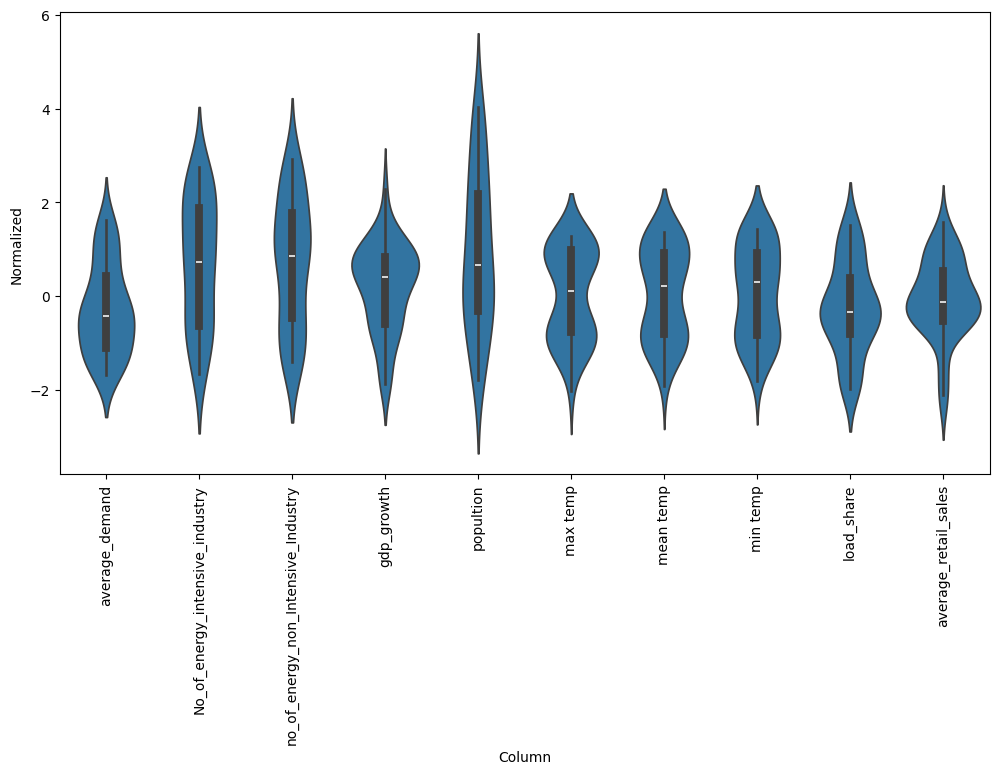

In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [13]:
w1 = WindowGenerator(input_width=7, label_width=1, shift=1,
                     label_columns=['average_demand'])
w1


Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['average_demand']

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['average_demand'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['average_demand']

In [16]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[20:20+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


2024-03-07 21:11:32.686497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 21:11:32.734399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
w2.example = example_inputs, example_labels

In [18]:
def plot(self, model=None, plot_col='average_demand', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Qaurters]')

WindowGenerator.plot = plot


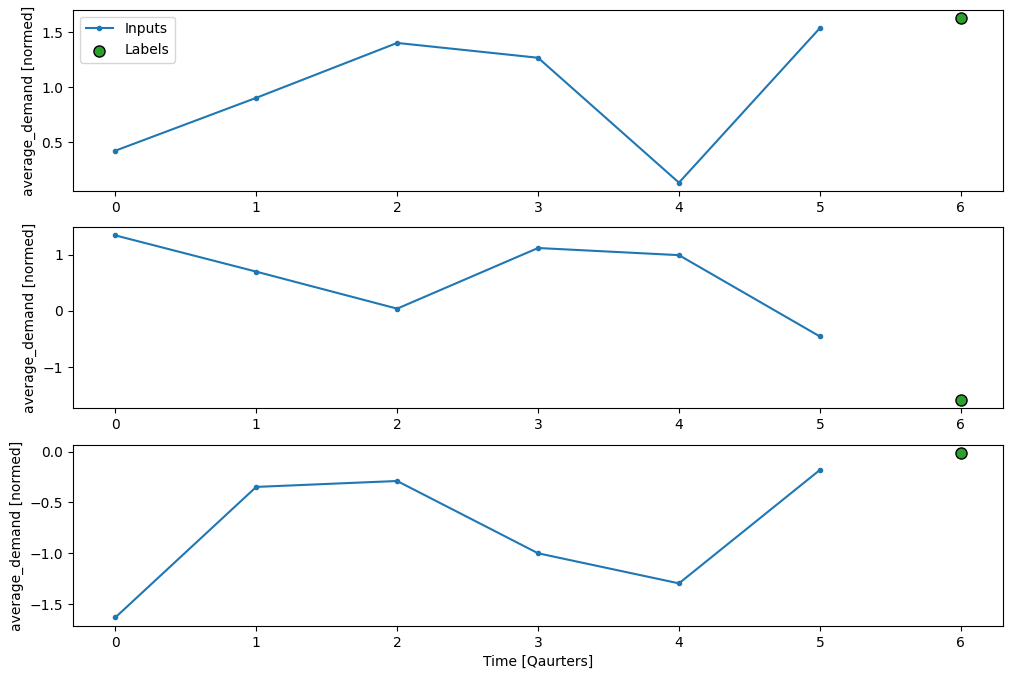

In [19]:
w2.plot()

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [22]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [23]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (24, 6, 10)
Labels shape (batch, time, features): (24, 1, 1)


In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['average_demand'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['average_demand']

In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (29, 1, 10)
Labels shape (batch, time, features): (29, 1, 1)


In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [27]:
baseline = Baseline(label_index=column_indices['average_demand'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAP' , dtype=None ),
                          tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE', dtype=None)
                          ])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


1/1 [==============================] - 0s 141ms/step - loss: 0.4420 - MAP: 0.5927 - MAPE: 78.3797


Input shape: (24, 6, 10)
Output shape: (24, 6, 1)


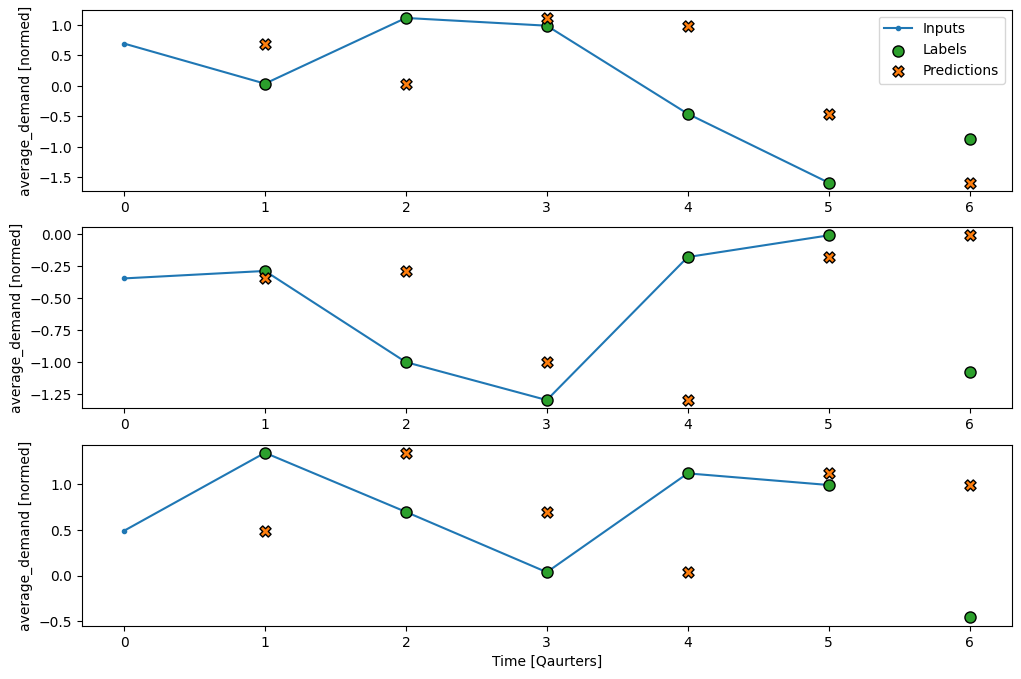

In [28]:
# try a wider window 
wide_window = WindowGenerator(
    input_width=6, label_width=6, shift=1,
    label_columns=['average_demand'])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(baseline)


### Linear Model

In [29]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10) , 
    tf.keras.layers.Dense(units=1) , 
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (29, 1, 10)
Output shape: (29, 1, 1)


In [30]:
MAX_EPOCHS = 20

def compile_and_fit(model, window,num_epochs=MAX_EPOCHS, patience=2 ):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(name="MAE") , 
                         tf.keras.metrics.MeanAbsolutePercentageError(name="MAPE")])

  history = model.fit(window.train, epochs=num_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [31]:
linear_history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
1/1 [==============================] - 1s 590ms/step - loss: 5.6879 - MAE: 2.1412 - MAPE: 1606.5940 - val_loss: 3.9880 - val_MAE: 1.9431 - val_MAPE: 269.1422
Epoch 2/20
1/1 [==============================] - 0s 42ms/step - loss: 5.5555 - MAE: 2.1150 - MAPE: 1566.2241 - val_loss: 3.8442 - val_MAE: 1.9071 - val_MAPE: 263.7945
Epoch 3/20
1/1 [==============================] - 0s 43ms/step - loss: 5.4254 - MAE: 2.0888 - MAPE: 1525.9683 - val_loss: 3.7032 - val_MAE: 1.8710 - val_MAPE: 258.4405
Epoch 4/20
1/1 [==============================] - 0s 46ms/step - loss: 5.2977 - MAE: 2.0627 - MAPE: 1485.8745 - val_loss: 3.5647 - val_MAE: 1.8348 - val_MAPE: 253.0689
Epoch 5/20
1/1 [==============================] - 0s 48ms/step - loss: 5.1725 - MAE: 2.0367 - MAPE: 1446.0022 - val_loss: 3.4283 - val_MAE: 1.7984 - val_MAPE: 247.6640
Epoch 6/20
1/1 [==============================] - 0s 41ms/step - loss: 5.0496 - MAE: 2.0108 - MAPE: 1406.4232 - val_loss: 3.2937 - val_MAE: 1.7615 - val_MAPE: 

Input shape: (24, 6, 10)
Output shape: (24, 6, 1)


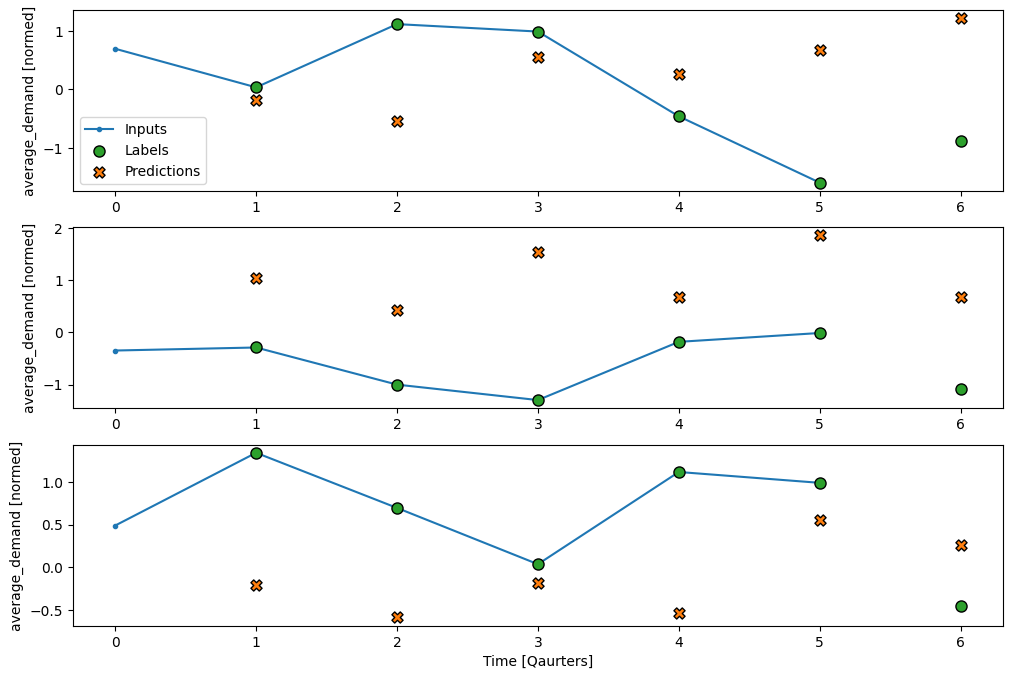

In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)
wide_window.plot(linear)

Text(0.5, 1.0, 'Average Importance of each feature from the Linear model (Explainability)')

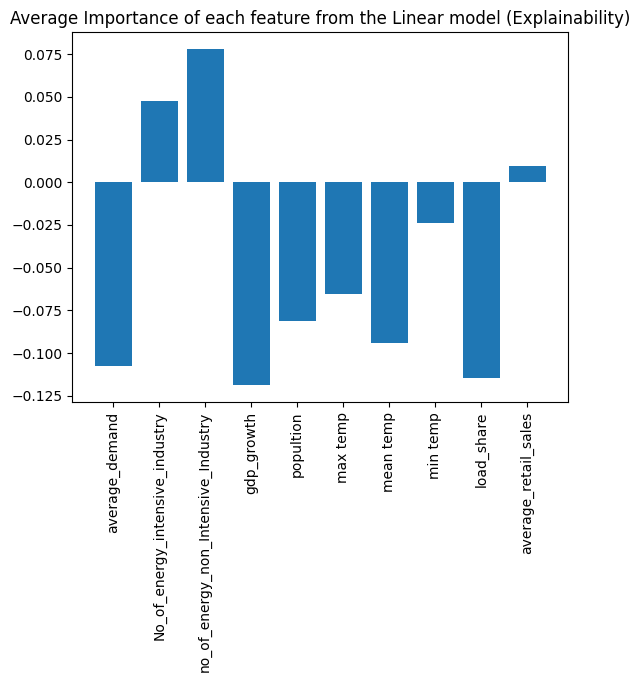

In [33]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel.numpy().mean(axis=1))
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)
plt.title("Average Importance of each feature from the Linear model (Explainability)")

### ANN model

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
1/1 [==============================] - 1s 692ms/step - loss: 1.2770 - MAE: 0.8881 - MAPE: 476.6671 - val_loss: 0.2343 - val_MAE: 0.4375 - val_MAPE: 70.4010
Epoch 2/20
1/1 [==============================] - 0s 42ms/step - loss: 1.1166 - MAE: 0.8272 - MAPE: 401.3029 - val_loss: 0.2308 - val_MAE: 0.4408 - val_MAPE: 68.2259
Epoch 3/20
1/1 [==============================] - 0s 41ms/step - loss: 0.9770 - MAE: 0.7719 - MAPE: 339.3171 - val_loss: 0.2303 - val_MAE: 0.4443 - val_MAPE: 66.4374
Epoch 4/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8562 - MAE: 0.7192 - MAPE: 281.5369 - val_loss: 0.2312 - val_MAE: 0.4471 - val_MAPE: 64.9568
Epoch 5/20
1/1 [==============================] - 0s 34ms/step - loss: 0.2329 - MAE: 0.4497 - MAPE: 63.9964


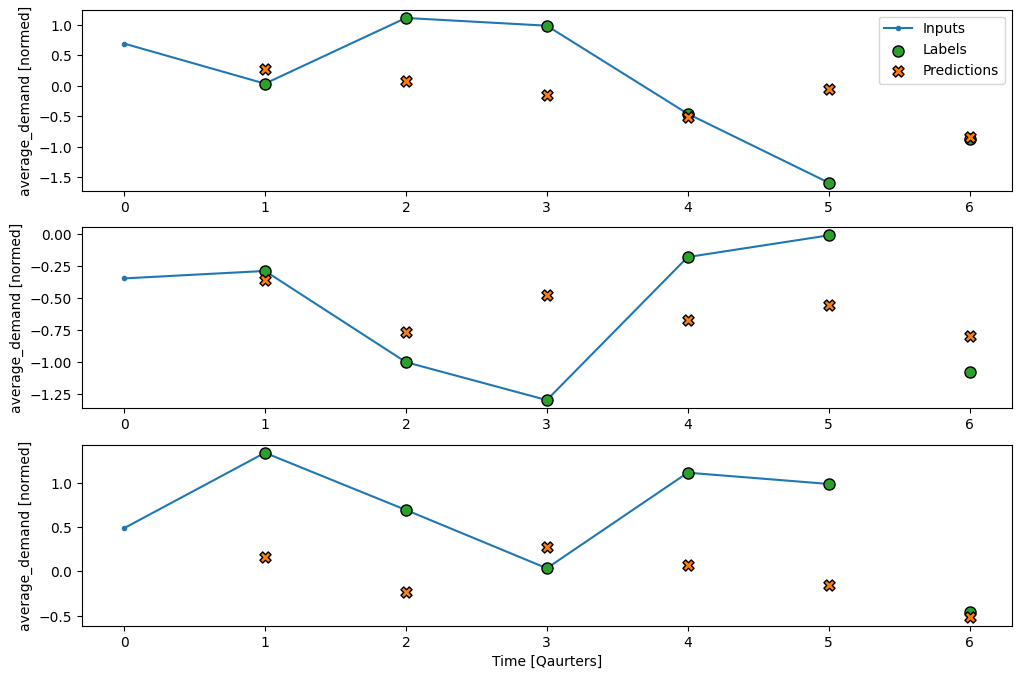

In [35]:
wide_window.plot(dense)

### CNN Model

In [36]:
# Handling multiple time steps to produce single output 
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['average_demand'])

conv_window


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['average_demand']

Text(0.5, 1.0, 'Given 3  qaurters of inputs, predict 1 hour into the future.')

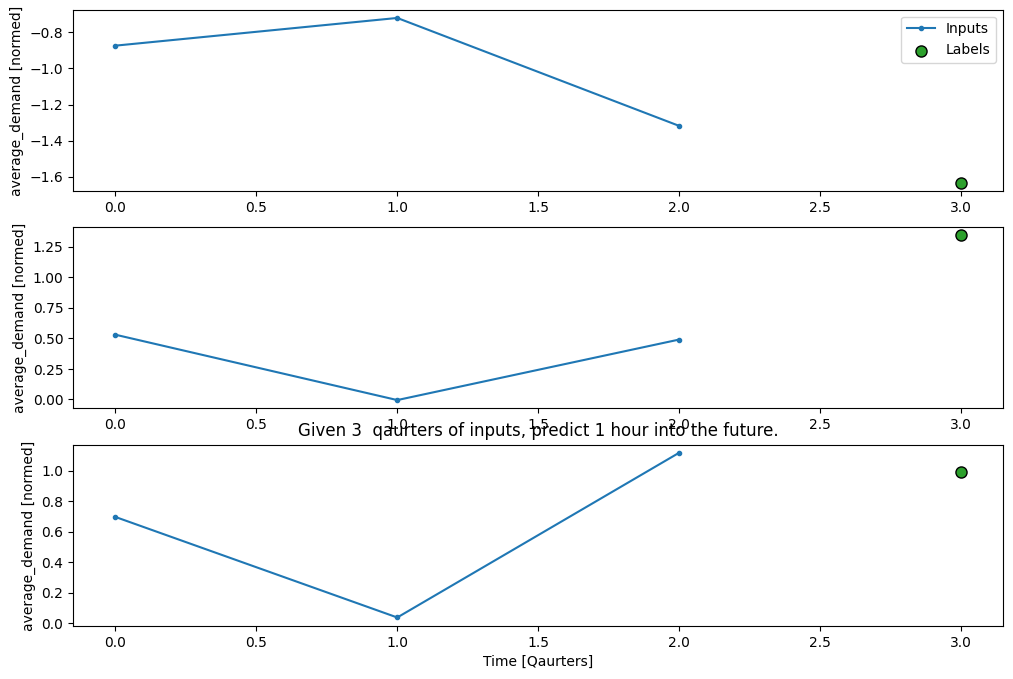

In [37]:
conv_window.plot()
plt.title("Given 3  qaurters of inputs, predict 1 hour into the future.")


In [38]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)



Conv model on `conv_window`
Input shape: (27, 3, 10)
Output shape: (27, 1, 1)


In [39]:
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


1/1 [==============================] - 0s 33ms/step - loss: 0.2853 - MAE: 0.4023 - MAPE: 44.6779


In [40]:
LABEL_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['average_demand'])
wide_conv_window


Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [3 4 5]
Label column name(s): ['average_demand']

In [41]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window


Input shape: (25, 5, 10)
Labels shape: (25, 3, 1)
Output shape: (25, 3, 1)


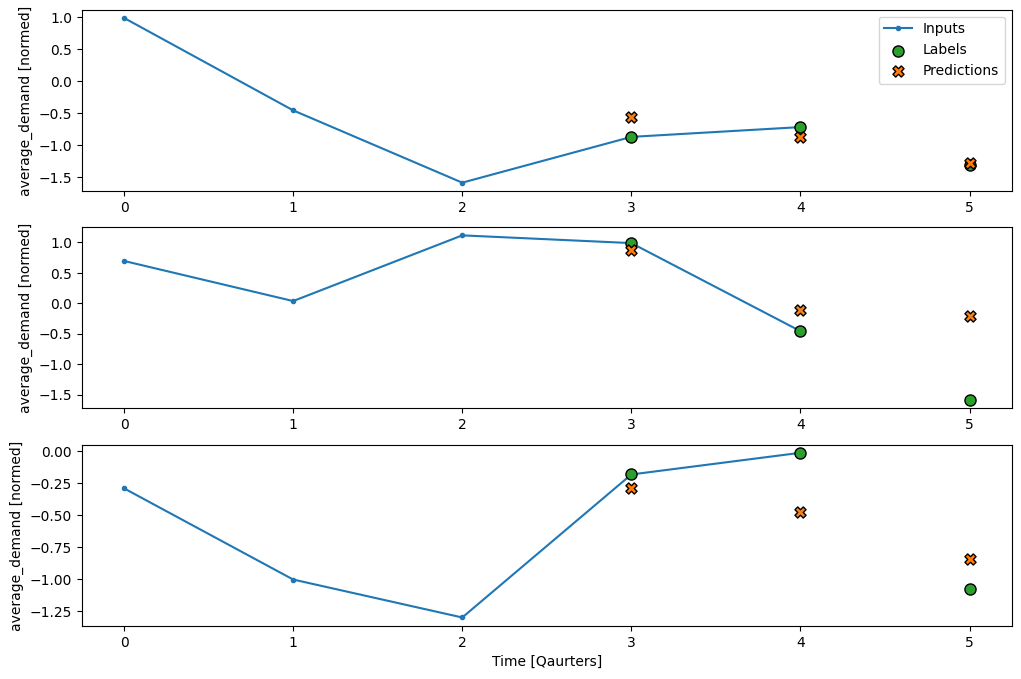

In [42]:
wide_conv_window.plot(conv_model)

In [43]:
wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1,
    label_columns=['average_demand'])

wide_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['average_demand']

In [44]:
rnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', rnn_model(wide_window.example[0]).shape)


Input shape: (26, 4, 10)
Output shape: (26, 4, 1)


In [46]:
history = compile_and_fit(rnn_model, wide_window,50,10)

val_performance['RNN'] = rnn_model.evaluate(wide_window.val)
performance['RNN'] = rnn_model.evaluate(wide_window.test, verbose=0)


Epoch 1/50
1/1 [==============================] - 1s 977ms/step - loss: 0.9473 - MAE: 0.7990 - MAPE: 448.2877 - val_loss: 0.5139 - val_MAE: 0.6321 - val_MAPE: 69.4680
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 0.8559 - MAE: 0.7529 - MAPE: 437.3236 - val_loss: 0.4555 - val_MAE: 0.5886 - val_MAPE: 64.7868
Epoch 3/50
1/1 [==============================] - 0s 44ms/step - loss: 0.7739 - MAE: 0.7097 - MAPE: 434.6521 - val_loss: 0.4043 - val_MAE: 0.5462 - val_MAPE: 60.2239
Epoch 4/50
1/1 [==============================] - 0s 43ms/step - loss: 0.7010 - MAE: 0.6683 - MAPE: 432.1899 - val_loss: 0.3603 - val_MAE: 0.5086 - val_MAPE: 56.3319
Epoch 5/50
1/1 [==============================] - 0s 42ms/step - loss: 0.6371 - MAE: 0.6312 - MAPE: 439.2205 - val_loss: 0.3231 - val_MAE: 0.4819 - val_MAPE: 54.3345
Epoch 6/50
1/1 [==============================] - 0s 44ms/step - loss: 0.5818 - MAE: 0.5967 - MAPE: 449.5476 - val_loss: 0.2923 - val_MAE: 0.4592 - val_MAPE: 53.0000
Epo

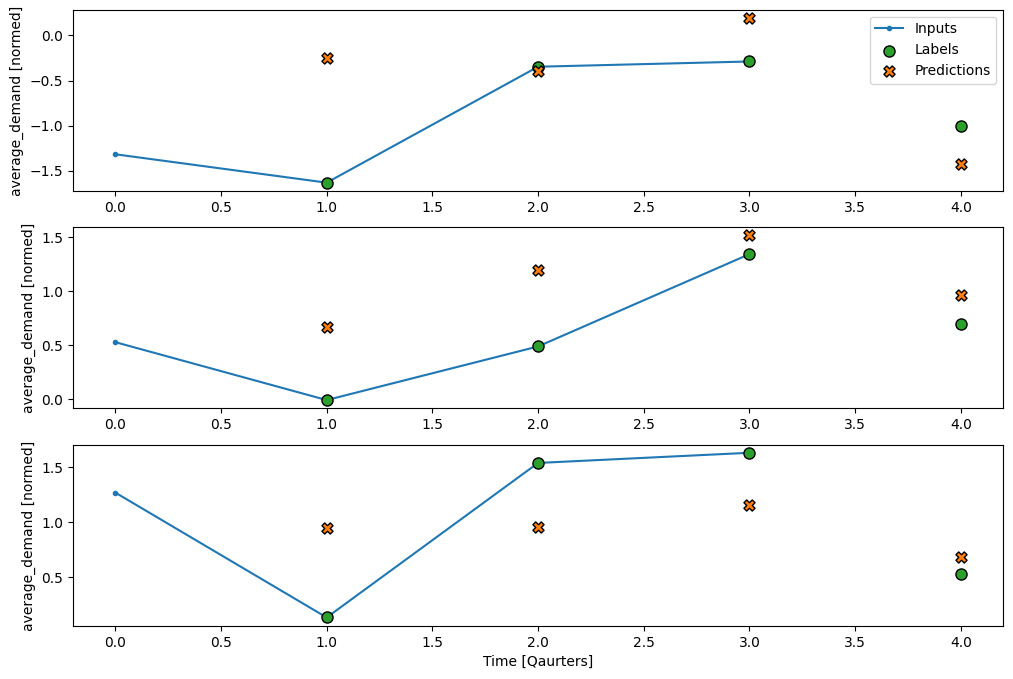

In [47]:
wide_window.plot(rnn_model)


### LSTM Model

In [48]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


1/1 [==============================] - 0s 34ms/step - loss: 0.5913 - MAE: 0.6092 - MAPE: 54.5584


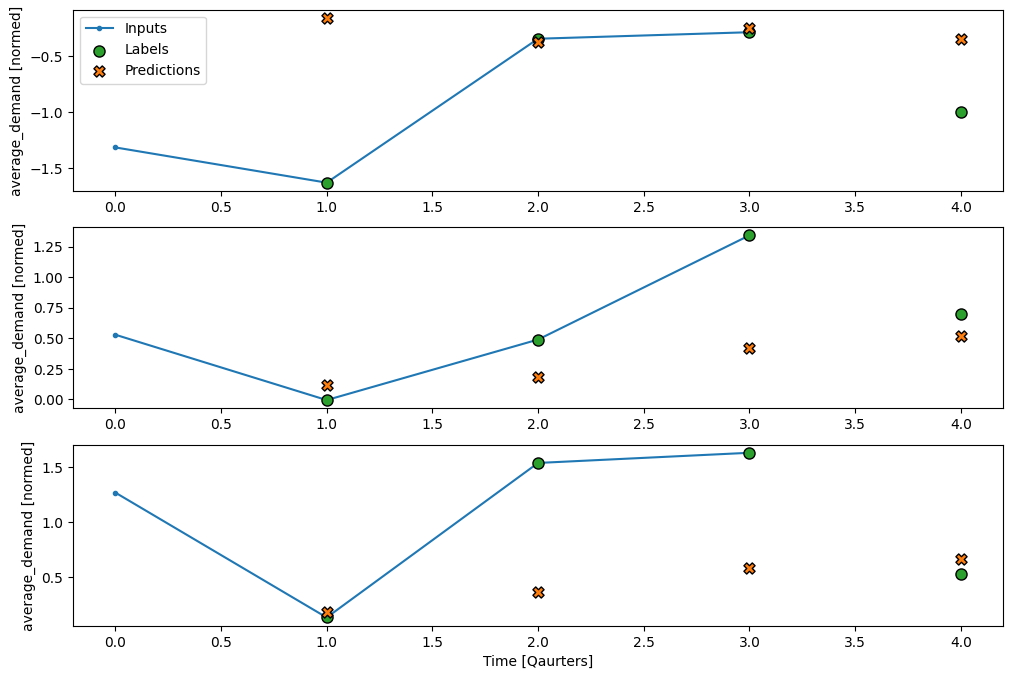

In [49]:
wide_window.plot(lstm_model)

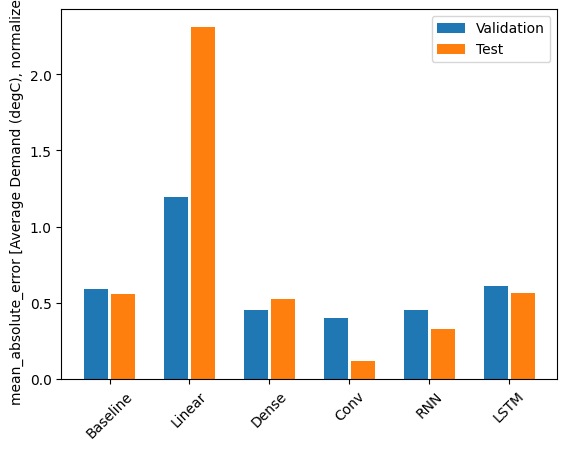

In [55]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'MAE'
metric_index = lstm_model.metrics_names.index('MAE')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Average Demand (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [60]:
pd.DataFrame(val_performance,index=lstm_model.metrics_names)

,Baseline,Linear,Dense,Conv,RNN,LSTM
loss,0.441955,1.591511,0.232948,0.285300,0.260027,0.591338
MAE,0.592687,1.192121,0.449695,0.402261,0.448570,0.609198
MAPE,78.379654,158.194595,63.996368,44.677944,51.620747,54.558399


In [61]:
pd.DataFrame(performance , index=lstm_model.metrics_names) 

,Baseline,Linear,Dense,Conv,RNN,LSTM
loss,0.406497,5.435116,0.309981,0.014186,0.191823,0.578749
MAE,0.554321,2.312194,0.520710,0.118966,0.325699,0.562789
MAPE,74.999229,309.093506,84.261063,20.510241,29.291252,48.929192


In [53]:
lstm_model.metrics_names

['loss', 'MAE', 'MAPE']

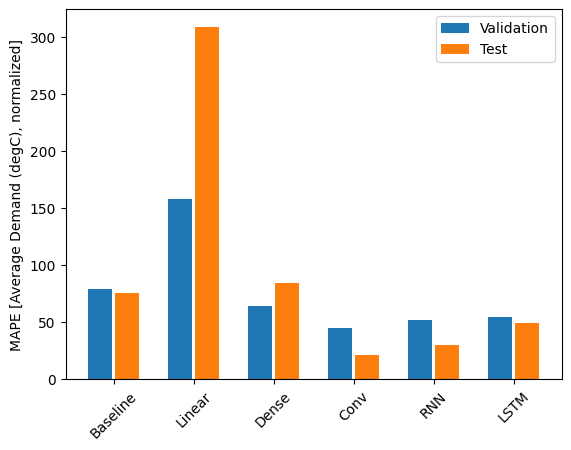

In [56]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'MAPE'
metric_index = lstm_model.metrics_names.index('MAPE')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('MAPE [Average Demand (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
